# How has the weather changed in the Willamette Valley of Oregon over the past century and how might it change in the future?

# Table of contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Datasources](#Datasources)
    - [Datasource exploration](#Datasourceexploration)
    - [Loading of stations data](#Loadingofstationsdata)
    - [Loading of weather data](#Loadingofweatherdata)
- [Cleaning](#Cleaning)
- [Transforming](#Transforming)
- [Visualizing](#Visualizing)
- [Modeling](#Modeling)
- [Evaluating](#Evaluating)
- [Concluding](#Concluding)

## Introduction <a name="Introduction"></a>
How has the weather changed in the Willamette Valley of Oregon over the past century and how might it change in the future? Our problem definition [document](https://docs.google.com/document/d/1KsZ-aHGVaS7dKo1_jgF2MjEo4TgpO4AT_gDP_TKO5Og/edit?usp=sharing) contains the details of the problem we wish to solve, including the specifics of the geographic region, which weather properties, & time periods. 

## Imports <a name="Imports"></a>
Loading Python modules and Notebook extentions.

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import google.cloud.bigquery as bq
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
%load_ext google.cloud.bigquery

## Datasources <a name="Datasources"></a>
As a weather datasource, I’ve selected the [NOAA](www.noaa.gov) public dataset on [Google Bigquery](https://console.cloud.google.com/marketplace/details/noaa-public/gsod).
This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center. This dataset covers GSOD data between 1929 and present, collected from over 9000 stations. 
The dataset ID is: 'bigquery-public-data:noaa_gsod'

To query, we will use Python API and move the data we need into Panda dataframes. 

We will also be using the reference points along our river of interest which we listed earlier, including their [geodata](https://geohack.toolforge.org/geohack.php?pagename=Cottage_Grove,_Oregon&params=43_47_41_N_123_3_9_W_type:city_region:US-OR): 

In [3]:
region_points = {
'Eugene': [44.051, -123.086], 
'Corvallis': [44.566, -123.283],
'Salem': [44.939, -123.039],
'Portland': [45.520, -122.681]
}

###  Datasource exploration <a name="Datasourceexploration"></a>
We will do some initial exploration of the data structure and contents. We need to determine if we have what we need for our study. 

In [4]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`

,table_catalog,table_schema,table_name,column_name,field_path,data_type,description
0,bigquery-public-data,noaa_gsod,gsod2020,date,date,DATE,Date of the weather observations
1,bigquery-public-data,noaa_gsod,gsod2021,date,date,DATE,Date of the weather observations
2,bigquery-public-data,noaa_gsod,stations,usaf,usaf,STRING,
3,bigquery-public-data,noaa_gsod,stations,name,name,STRING,
4,bigquery-public-data,noaa_gsod,stations,country,country,STRING,
...,...,...,...,...,...,...,...
2984,bigquery-public-data,noaa_gsod,gsod1966,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2985,bigquery-public-data,noaa_gsod,gsod1932,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2986,bigquery-public-data,noaa_gsod,gsod2019,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2987,bigquery-public-data,noaa_gsod,gsod2014,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."


In [5]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMNS`

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,bigquery-public-data,noaa_gsod,gsod2000,stn,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
1,bigquery-public-data,noaa_gsod,gsod2000,wban,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2,bigquery-public-data,noaa_gsod,gsod2000,year,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
3,bigquery-public-data,noaa_gsod,gsod2000,mo,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
4,bigquery-public-data,noaa_gsod,gsod2000,da,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,bigquery-public-data,noaa_gsod,gsod2003,rain_drizzle,28,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2985,bigquery-public-data,noaa_gsod,gsod2003,snow_ice_pellets,29,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2986,bigquery-public-data,noaa_gsod,gsod2003,hail,30,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2987,bigquery-public-data,noaa_gsod,gsod2003,thunder,31,YES,STRING,NEVER,None,None,NO,None,NO,NO,None


We are seeing thousands of columns because the data is broken up into a separate table for every year. 

In [6]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.TABLES`

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time
0,bigquery-public-data,noaa_gsod,gsod2000,BASE TABLE,YES,NO,2016-03-14 02:55:34.341000+00:00
1,bigquery-public-data,noaa_gsod,gsod2001,BASE TABLE,YES,NO,2016-03-14 02:55:31.232000+00:00
2,bigquery-public-data,noaa_gsod,gsod1933,BASE TABLE,YES,NO,2016-03-14 02:55:02.293000+00:00
3,bigquery-public-data,noaa_gsod,gsod1942,BASE TABLE,YES,NO,2016-03-14 02:55:06.381000+00:00
4,bigquery-public-data,noaa_gsod,gsod1963,BASE TABLE,YES,NO,2016-03-14 02:55:17.608000+00:00
...,...,...,...,...,...,...,...
89,bigquery-public-data,noaa_gsod,gsod1966,BASE TABLE,YES,NO,2016-03-14 02:55:15.947000+00:00
90,bigquery-public-data,noaa_gsod,gsod1932,BASE TABLE,YES,NO,2016-03-14 02:55:01.279000+00:00
91,bigquery-public-data,noaa_gsod,gsod2019,BASE TABLE,YES,NO,2019-01-11 17:03:04.031000+00:00
92,bigquery-public-data,noaa_gsod,gsod2014,BASE TABLE,YES,NO,2016-03-14 02:55:37.586000+00:00


To aggregate the tables for every year, we will use table queries with a wildcard ‘gsod*’.

In [7]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.gsod*`
Limit 10

,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,230660,99999,None,1936,05,11,10.3,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
1,230660,99999,None,1936,10,08,31.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
2,238490,99999,None,1936,01,10,0.5,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
3,238490,99999,None,1936,05,03,26.8,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
4,249440,99999,None,1936,01,11,-20.2,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
5,249440,99999,None,1936,03,18,7.7,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
6,280440,99999,None,1936,10,22,34.7,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
7,282250,99999,None,1936,11,16,32.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
8,283670,99999,None,1936,01,18,2.5,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
9,283670,99999,None,1936,04,29,29.3,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0


Many fields have place-holder values of 99.99 or similar so we will have to do cleaning but for now we continue exploring. 

The only other table we see is for info about the weather stations. We will need it to narrow down our weather data to only our region of interest. 

In [8]:
%%bigquery
SELECT column_name, data_type, description
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'stations'

,column_name,data_type,description
0,usaf,STRING,
1,wban,STRING,
2,name,STRING,
3,country,STRING,
4,state,STRING,
5,call,STRING,
6,lat,FLOAT64,
7,lon,FLOAT64,
8,elev,STRING,
9,begin,STRING,


In [9]:
%%bigquery
SELECT column_name, data_type, description
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'gsod1963'

,column_name,data_type,description
0,stn,STRING,Station number (WMO/DATSAV3 number) for the lo...
1,wban,STRING,WBAN number where applicable--this is the hist...
2,year,STRING,The year
3,mo,STRING,The month
4,da,STRING,The day
5,temp,FLOAT64,Mean temperature for the day in degrees Fahren...
6,count_temp,INT64,Number of observations used in calculating mea...
7,dewp,FLOAT64,Mean dew point for the day in degreesm Fahrenh...
8,count_dewp,INT64,Number of observations used in calculating mea...
9,slp,FLOAT64,Mean sea level pressure for the day in milliba...


The NOAA collects hourly data so trends can be seen over different times of day. 
Here, there is no field for hour or time so this dataset must be of daily summaries of the hourly data. 
For our purposes, that will be sufficient. 

It looks like to join the tables we'll sometimes need to use usaf but for other stations we'll need wban as the common index. We can probably create a unified index that works by either looking for 99999 in both columns and doing two separate queries or by concatenating the id columns of both tables. 

#### Loading of stations data <a name="Loadingofstationsdata"></a>
We will not be loading our actual weather data until we have narrowed down our stations to table join with. 

In [10]:
%%bigquery stationsdf
SELECT
usaf as station_id1,
wban as station_id2, 
name, state, lat, lon, elev
FROM `bigquery-public-data.noaa_gsod.stations`

In [11]:
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev
0,007018,99999,WXPOD 7018,None,0.00,0.000,+7018.0
1,007026,99999,WXPOD 7026,None,0.00,0.000,+7026.0
2,007070,99999,WXPOD 7070,None,0.00,0.000,+7070.0
3,008268,99999,WXPOD8278,None,32.95,65.567,+1156.7
4,008307,99999,WXPOD 8318,None,0.00,0.000,+8318.0


Some stations have lat/lon set to 0.00. 

In [12]:
%%bigquery
SELECT count(*) 
FROM `bigquery-public-data.noaa_gsod.stations`
WHERE lat = 0

,f0_
0,385


So we have 385 stations with no location data. 

In [13]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.stations`
WHERE usaf = '007018'

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.0,0.0,+7018.0,20110309,20130730


In [14]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE stn = '007018'
Limit 100

,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,007018,99999,None,2013,07,29,81.0,9,71.8,9,...,*,0.0,I,999.9,0,0,0,0,0,0
1,007018,99999,None,2013,07,14,79.6,24,77.3,24,...,*,0.0,I,999.9,0,0,0,0,0,0
2,007018,99999,None,2013,07,11,79.7,24,74.1,24,...,*,0.0,I,999.9,0,0,0,0,0,0
3,007018,99999,None,2013,07,16,87.7,17,76.5,17,...,*,0.0,I,999.9,0,0,0,0,0,0
4,007018,99999,None,2013,07,12,74.4,24,74.2,24,...,*,0.0,I,999.9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,007018,99999,None,2011,04,03,59.5,24,33.5,24,...,*,0.0,I,999.9,0,0,0,0,0,0
96,007018,99999,None,2011,04,11,72.5,24,62.8,24,...,*,0.0,I,999.9,0,0,0,0,0,0
97,007018,99999,None,2011,04,12,72.7,24,60.6,24,...,*,0.0,I,999.9,0,0,0,0,0,0
98,007018,99999,None,2011,04,15,67.0,24,48.0,24,...,*,0.0,I,999.9,0,0,0,0,0,0


The locations do have weather data but we won't be able to use them unless there's a way to get their location information. 

In [15]:
stationsdf.dtypes

station_id1     object
station_id2     object
name            object
state           object
lat            float64
lon            float64
elev            object
dtype: object

In [16]:
stationsdf.elev = pd.to_numeric(stationsdf.elev)

In [17]:
stationsdf.dtypes

station_id1     object
station_id2     object
name            object
state           object
lat            float64
lon            float64
elev           float64
dtype: object

In [18]:
stationsdf.describe()

,lat,lon,elev
count,28375.000000,28374.000000,28276.000000
mean,30.603388,-2.972035,346.062845
std,28.901886,87.265947,591.779195
min,-90.000000,-179.983000,-999.900000
25%,20.717000,-82.566750,22.000000
50%,39.000000,6.113500,138.000000
75%,49.783000,60.196000,432.625000
max,83.650000,179.750000,8318.000000


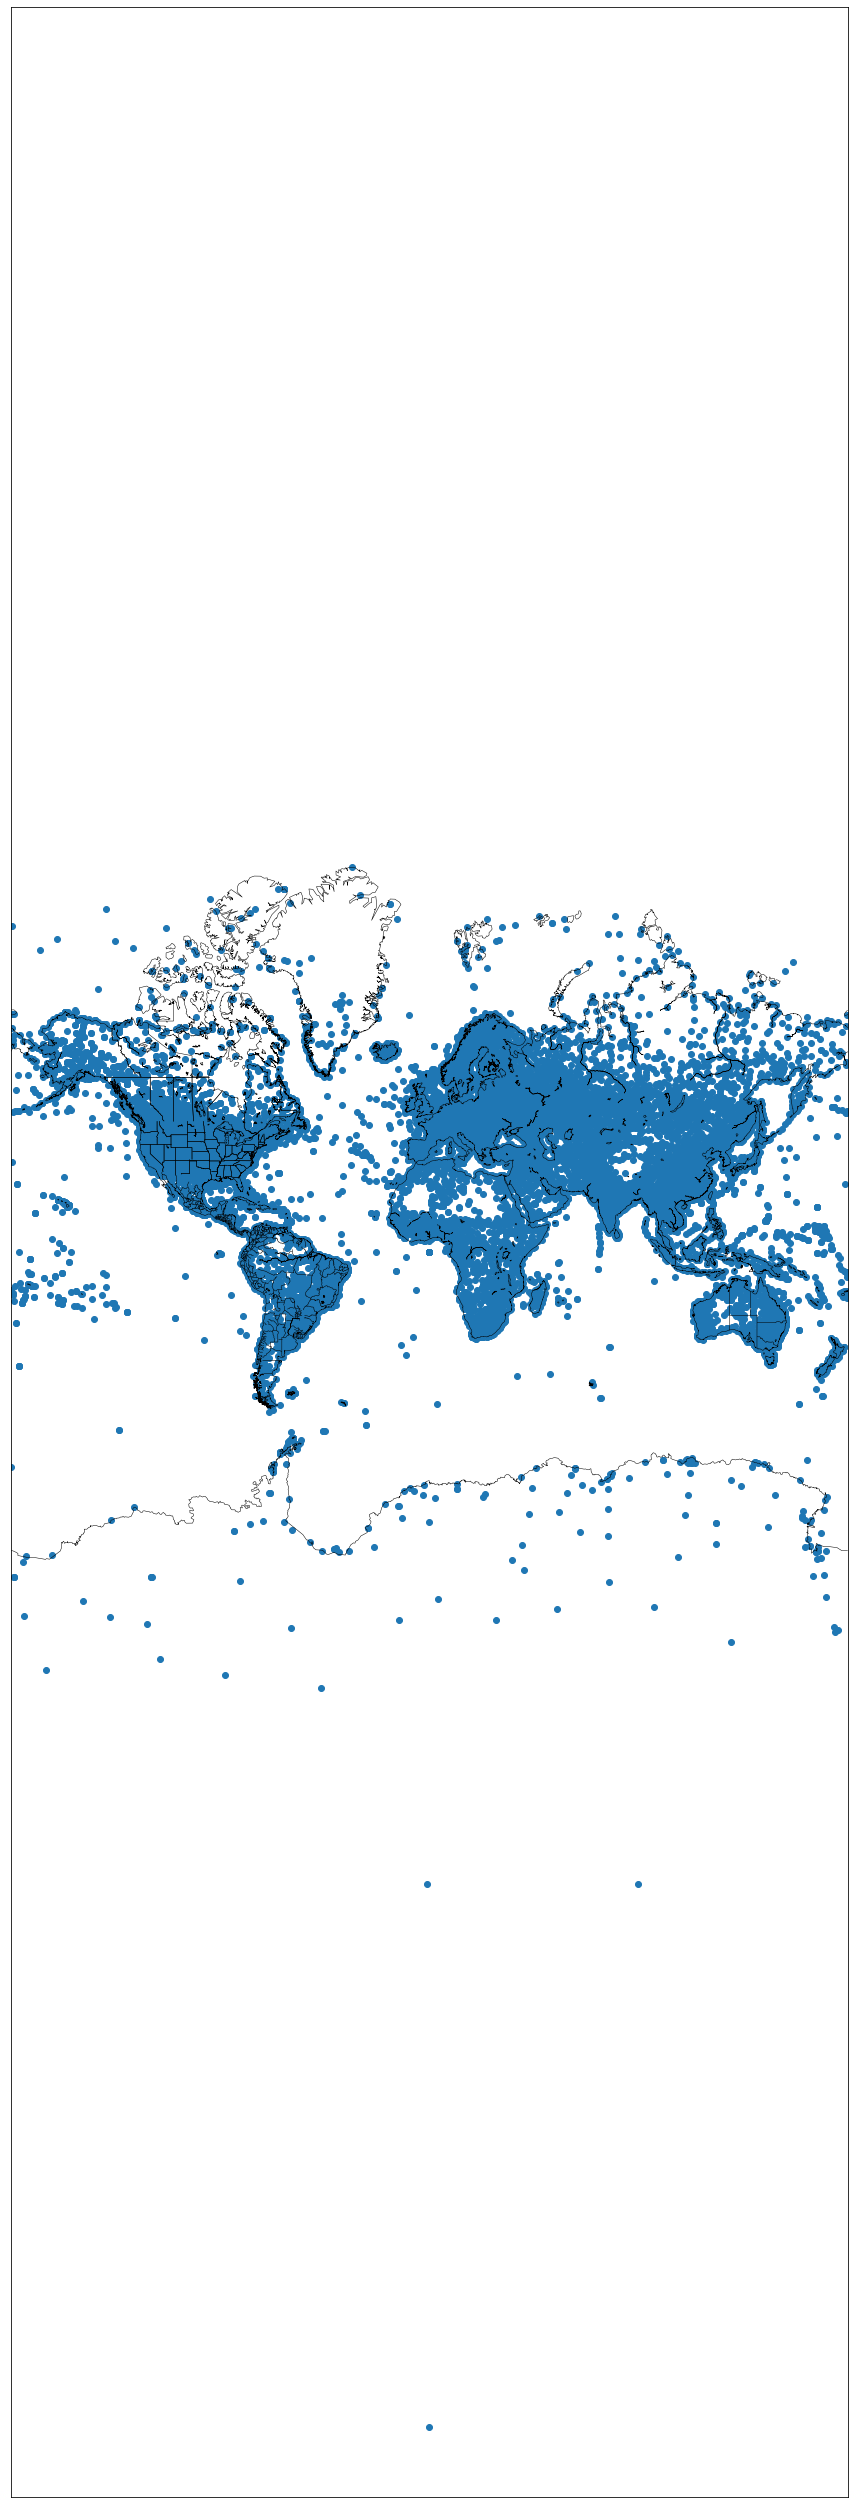

In [19]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,50)
m = Basemap(resolution='l',projection='merc')
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y)

Hundreds of stations have only 0,0 coordinates but enough others appear to have valid location data that we are reading correctly. 

We will calculate the distances between the stations and each of our region points. To do so, we apply the archaversine after computing the haversine of the central angle as described [here](https://en.wikipedia.org/wiki/Haversine_formula#Formulation) and shown below: ![Haversine method](https://wikimedia.org/api/rest_v1/media/math/render/svg/a65dbbde43ff45bacd2505fcf32b44fc7dcd8cc0) Using the produced distances will allow us to drop all stations outside our region from our selection before we join it with the weather data table. 

In [20]:
def rarchavh(point1lat, point1lon, point2lat, point2lon):
    """https://en.wikipedia.org/wiki/Haversine_formula#Formulation"""
    r = 6378 # radius of Earth in km
    phi1, lam1, phi2, lam2 = [np.radians(p) for p in [point1lat, point1lon, point2lat, point2lon]] # radians
    h = np.sin((phi2-phi1)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lam2-lam1)/2)**2 # haversine
    d = 2 * r * np.arcsin(h**.5) # spherical distance = r archav(h)
    return d

In [21]:
#Get distances from each of our reference points in the region
for k, v in region_points.items():
    stationsdf['dist'+k] = rarchavh(
    v[0], v[1], stationsdf.lat, stationsdf.lon)

In [22]:
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev,distEugene,distCorvallis,distSalem,distPortland
0,007018,99999,WXPOD 7018,None,0.00,0.000,7018.0,12590.038891,12580.491203,12545.614905,12493.144656
1,007026,99999,WXPOD 7026,None,0.00,0.000,7026.0,12590.038891,12580.491203,12545.614905,12493.144656
2,007070,99999,WXPOD 7070,None,0.00,0.000,7070.0,12590.038891,12580.491203,12545.614905,12493.144656
3,008268,99999,WXPOD8278,None,32.95,65.567,1156.7,11420.650612,11361.763195,11323.105059,11262.462705
4,008307,99999,WXPOD 8318,None,0.00,0.000,8318.0,12590.038891,12580.491203,12545.614905,12493.144656


In [23]:
stationsdf['distMin'] = stationsdf.iloc[:, -1:-len(region_points)-1:-1].min(axis=1)

In [24]:
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev,distEugene,distCorvallis,distSalem,distPortland,distMin
0,007018,99999,WXPOD 7018,None,0.00,0.000,7018.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
1,007026,99999,WXPOD 7026,None,0.00,0.000,7026.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
2,007070,99999,WXPOD 7070,None,0.00,0.000,7070.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
3,008268,99999,WXPOD8278,None,32.95,65.567,1156.7,11420.650612,11361.763195,11323.105059,11262.462705,11262.462705
4,008307,99999,WXPOD 8318,None,0.00,0.000,8318.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656


Color stations by distance from Willamette: 

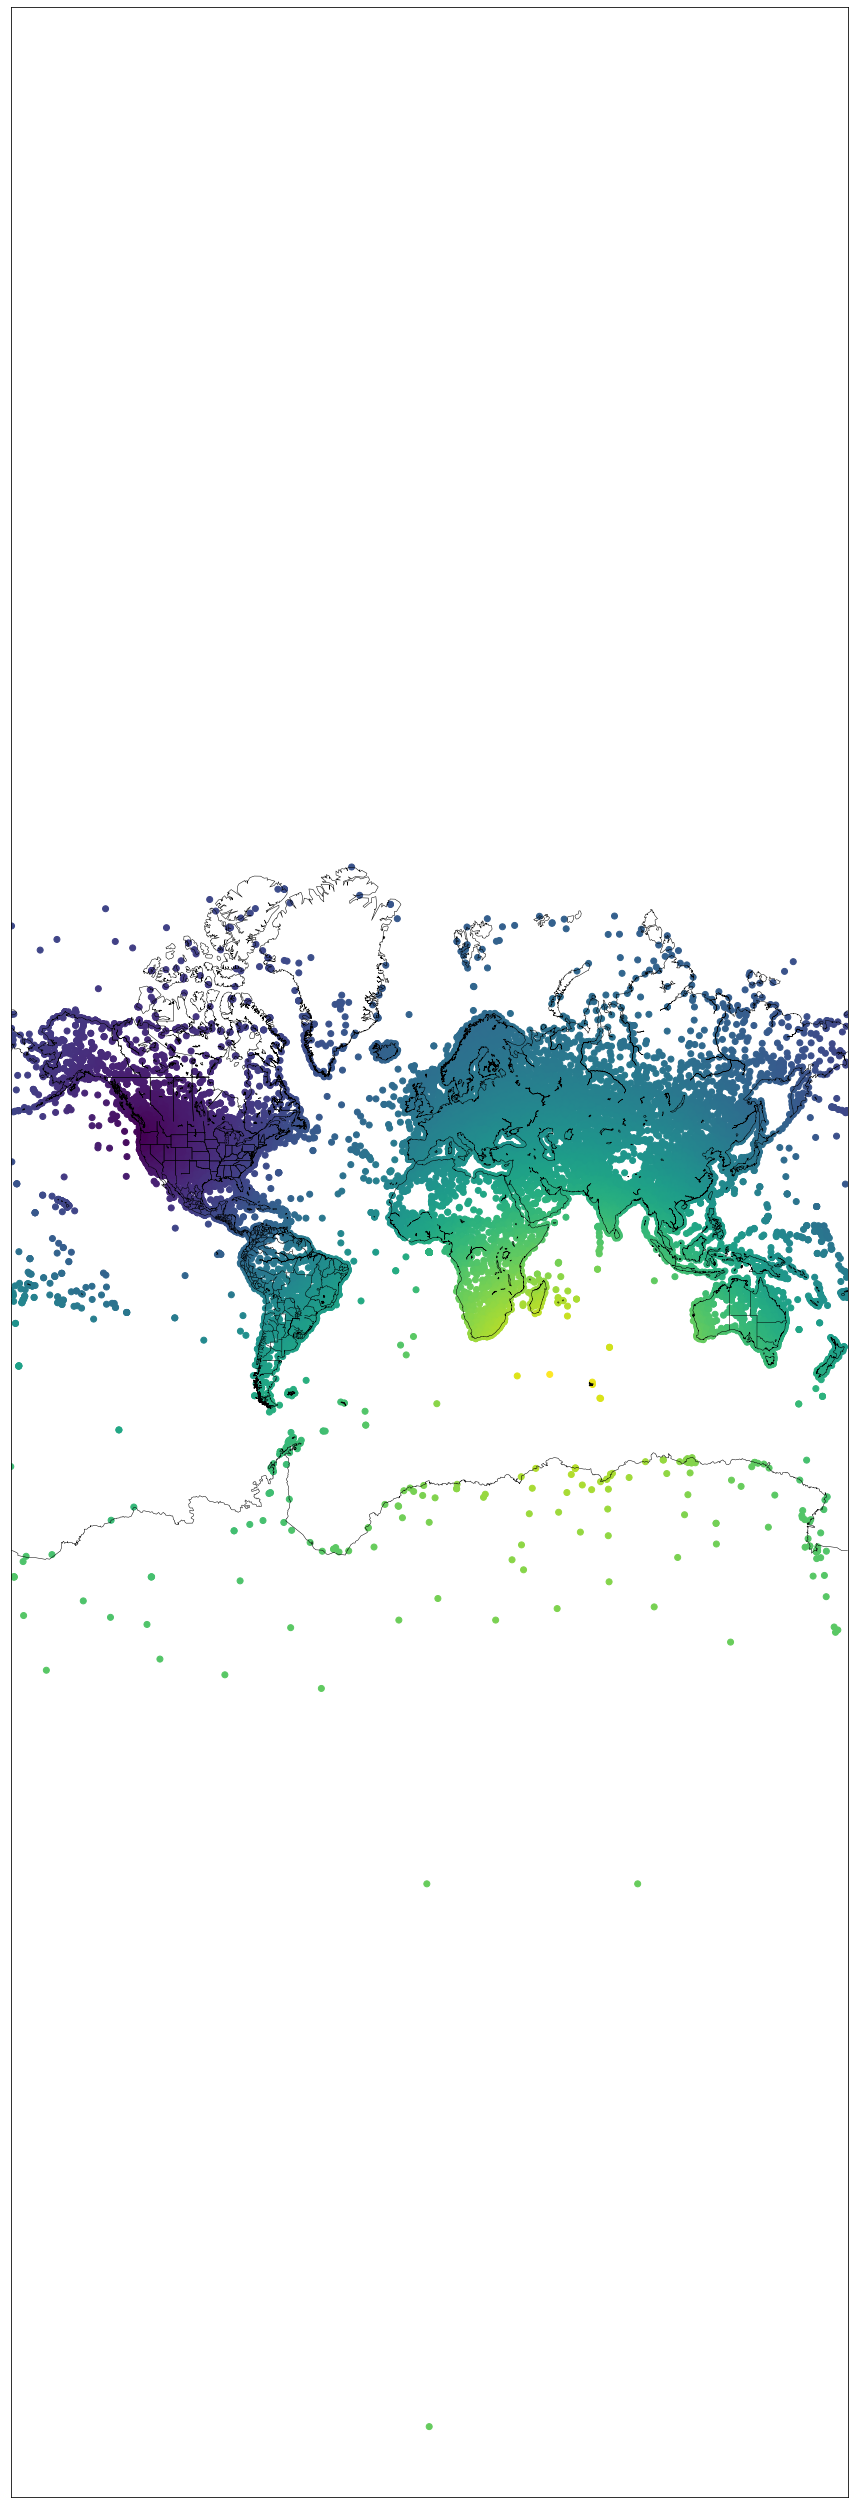

In [25]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,50)
m = Basemap(resolution='l',projection='merc')
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y, c=stationsdf['distMin'].values)

In [26]:
#We'll use this for a map centering point from now on
clat = region_points['Eugene'][0]
clon = region_points['Eugene'][1]

Color code the nearby stations: 

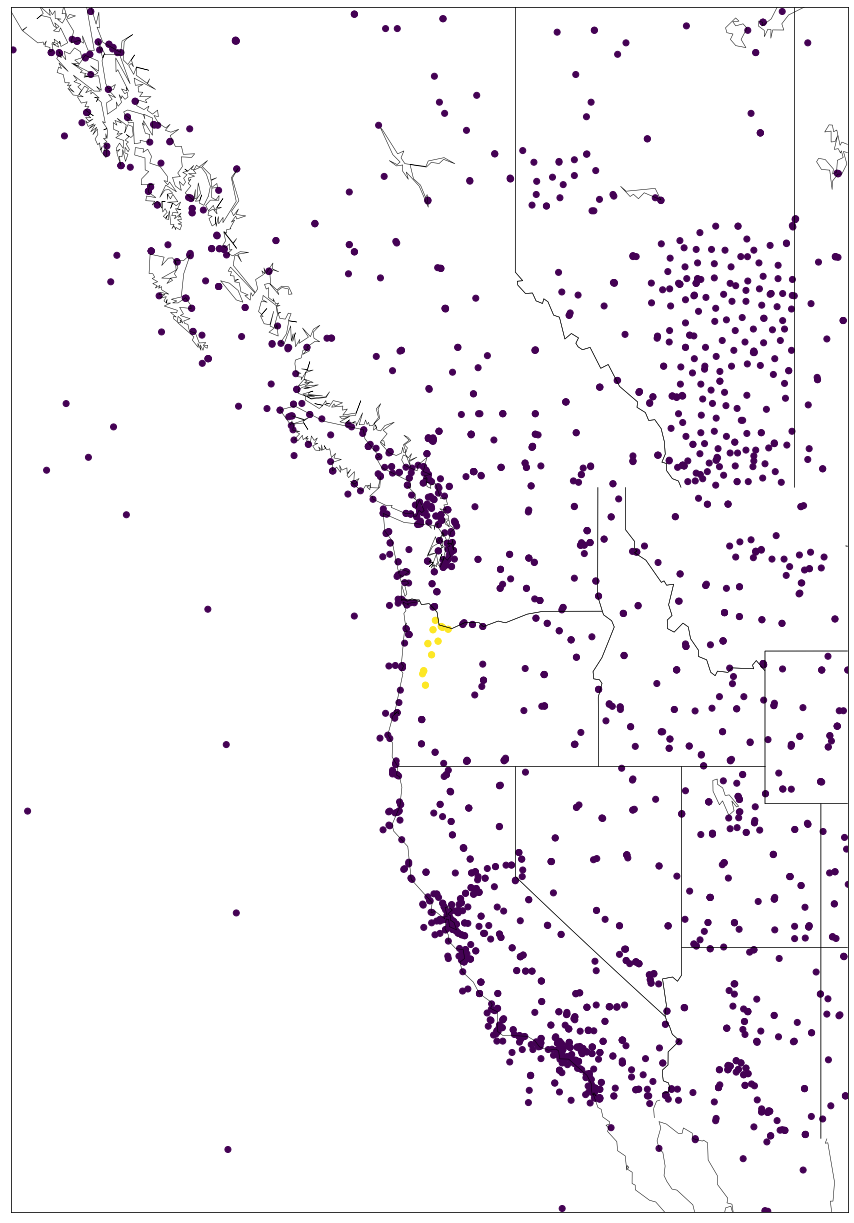

In [27]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,50)
m = Basemap(resolution='l',projection='merc',  
           llcrnrlat=clat-15,urcrnrlat=clat+15,llcrnrlon=clon-15,urcrnrlon=clon+15,lat_ts=15.0)
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y, c=stationsdf['distMin'].values < 60)

In [28]:
our_stations = stationsdf[
    (stationsdf.state == 'OR') & (stationsdf.elev < 500) & (stationsdf.distMin < 60)][
    ['station_id1', 'station_id2', 'name', 'lat', 'lon', 'elev', 'distMin']]

In [29]:
our_stations[:]

,station_id1,station_id2,name,lat,lon,elev,distMin
10213,999999,24248,CORVALLIS NAAS,44.500,-123.283,75.0,7.346929
14673,999999,24221,EUGENE MAHLON SWEET ARPT,44.128,-123.221,113.7,13.783134
14676,999999,24229,PORTLAND,45.596,-122.609,32.6,10.152165
14678,999999,24232,SALEM MCNARY FIELD,44.905,-123.001,61.3,4.826550
16403,726836,99999,SCAPPOOSE INDUSTRIAL,45.773,-122.867,18.0,31.665077
16405,726881,99999,MC MINNVILLE MUNI,45.183,-123.133,50.0,28.149047
16407,726945,99999,CORVALLIS MUNI,44.483,-123.283,75.0,9.239319
16408,726959,99999,AURORA STATE,45.250,-122.767,61.0,30.798502
16409,726986,99999,PORTLAND/HILLSBORO,45.533,-122.950,62.0,21.028200
16621,726985,99999,PORTLAND TROUTDALE,45.550,-122.400,12.0,22.163903


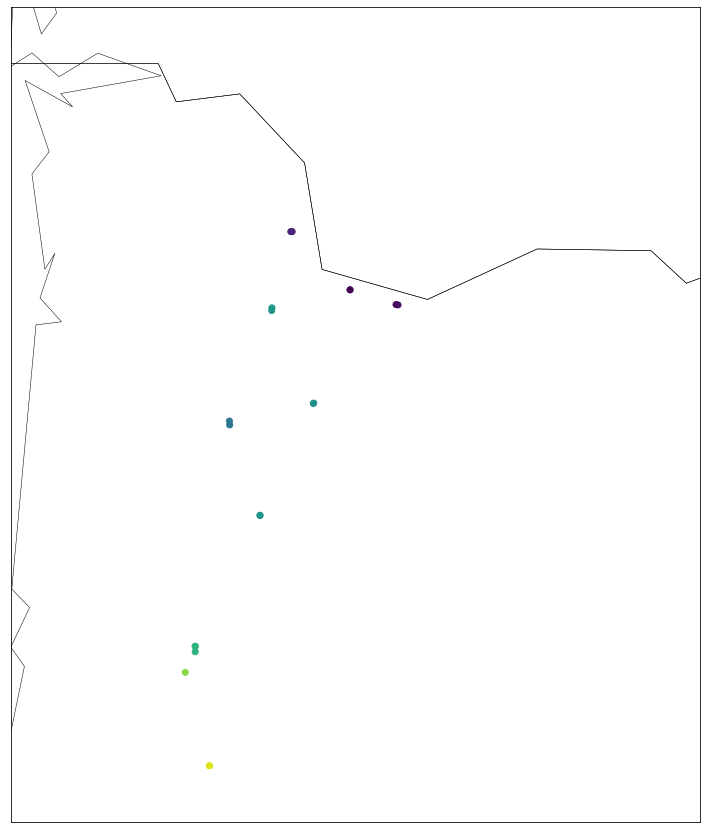

In [30]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,15)
m = Basemap(resolution='l',projection='merc',  
           llcrnrlat=clat-0.1,urcrnrlat=clat+2.4,llcrnrlon=clon-1,urcrnrlon=clon+2,lat_ts=0)
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(our_stations['lon'].values,our_stations['lat'].values)
m.scatter(x,y, c=our_stations['elev'].values)

Colored for elevation, we see the lowest stations are closest to the river's confluence in the North, while the highest stations are nearest its headwaters.
We ended up with only 20 valid stations but they have a pretty good spread over our region of interest so we are going to proceed with this data. 

#### Loading of weather data <a name="Loadingofweatherdata"></a>
Now that we have selected our stations, we next want to query for our weather data. We will select only records for our stations of interest, using a table join.